In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('main.csv')

In [6]:
# df = df.sort_values('Год').reset_index(drop=True)


# df = df.set_index('Год')

# Создаём новый индекс с шагом 0.25 года 
# full_index = np.arange(df.index.min(), df.index.max() + 0.25, 0.25)
# df = df.reindex(full_index)

# Интерполируем все числовые значения
# df_interpolated = df.interpolate(method='linear')


# df_interpolated = df_interpolated.reset_index().rename(columns={'index': 'Год'})

# df_interpolated['Год'] = df_interpolated['Год'].round(2)


df_interpolated = df

In [4]:
df

,Unnamed: 0,Год,Цена,Район,Ковид,Санкции,Ключевая ставка ЦБ РФ (%),ИПЦ (% к декабрю предыдущего года),Доллар
0,0,2000,14211.886305,126,0,0,28.0,119.3,28.8300
1,1,2000,21935.864647,43,0,0,28.0,119.3,28.8300
2,2,2000,16085.271318,124,0,0,28.0,119.3,28.8300
3,3,2000,14402.636054,10,0,0,28.0,119.3,28.8300
4,4,2000,13800.085251,99,0,0,28.0,119.3,28.8300
...,...,...,...,...,...,...,...,...,...
3297,3297,2025,328528.249244,84,0,2,21.0,110.2,89.0444
3298,3298,2025,416127.426580,83,0,2,21.0,110.2,89.0444
3299,3299,2025,234446.432121,126,0,2,21.0,110.2,89.0444
3300,3300,2025,336232.741617,1,0,2,21.0,110.2,89.0444


In [ ]:
df_interpolated

In [7]:
test_years = df_interpolated['Год'].max() - 1 

In [8]:
train_df = df_interpolated[df_interpolated['Год'] < test_years].copy()
test_df = df_interpolated[df_interpolated['Год'] >= test_years].copy()

In [10]:
features = ['Ковид', 'Санкции', 'Ключевая ставка ЦБ РФ (%)', 'Доллар', 'ИПЦ (% к декабрю предыдущего года)', 'Год', 'Район']
target = 'Цена'

In [11]:
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

In [12]:
print(f"🧪 Тренировочная выборка: {X_train.shape[0]} кварталов")
print(f"🧾 Тестовая выборка: {X_test.shape[0]} кварталов")

🧪 Тренировочная выборка: 3048 кварталов
🧾 Тестовая выборка: 254 кварталов


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R2 Score': r2
    }

In [13]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Модель
mlp = MLPRegressor(random_state=42, max_iter=1000)

# Сетка параметров
param_grid = {
    'hidden_layer_sizes': [(64,), (64, 32), (128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],  # регуляризация
    'learning_rate': ['constant', 'adaptive'],
    'batch_size': [32, 64]
}

# Мера качества (отрицательный MSE для GridSearch)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Обучение
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# Лучшая модель
best_mlp = grid_search.best_estimator_

# Предсказания
y_pred = best_mlp.predict(X_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Лучшие параметры: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 32, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'solver': 'adam'}


In [16]:
evaluate_model(y_test, y_pred)

{'MAE': 52126.22014164492,
 'MSE': 4883206090.628575,
 'RMSE': np.float64(69879.94054539954),
 'MAPE (%)': np.float64(18.159802831075446),
 'R2 Score': 0.0028061792728848456}

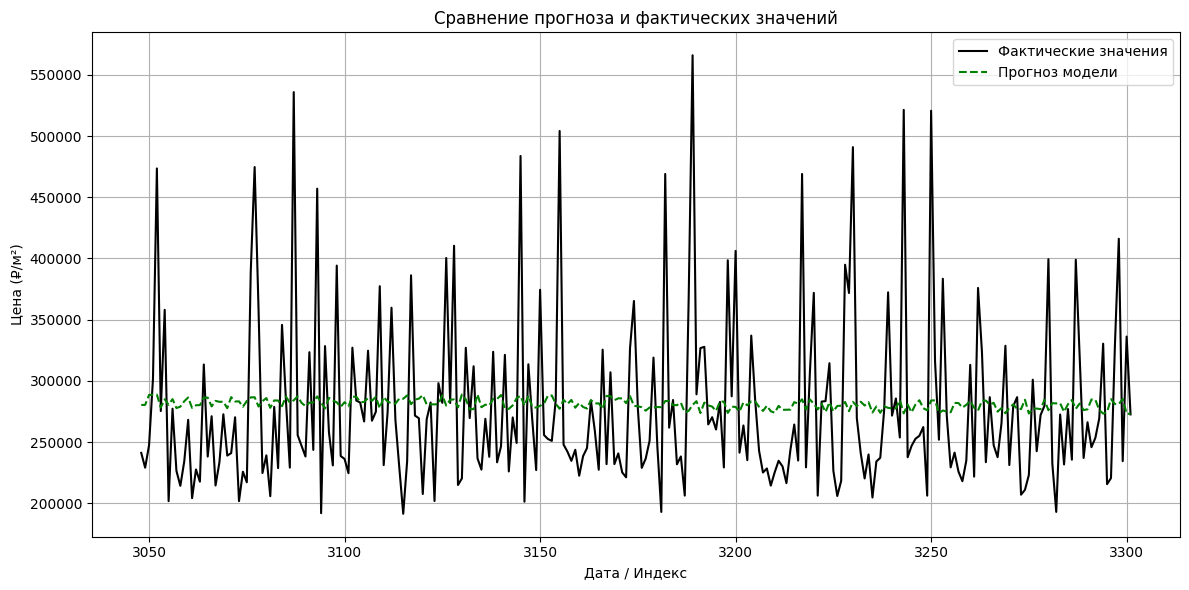

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(y_test.index, y_test.values, label='Фактические значения', color='black')
plt.plot(y_test.index, y_pred, label='Прогноз модели', color='green', linestyle='--')

plt.title('Сравнение прогноза и фактических значений')
plt.xlabel('Дата / Индекс')
plt.ylabel('Цена (₽/м²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
y_pred = best_mlp.predict(df_interpolated[features])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df_interpolated.index, df_interpolated[target], label='Фактические значения', color='black')
plt.plot(df_interpolated.index, y_pred, label='Прогноз модели', color='green', linestyle='--')

plt.title('Сравнение прогноза и фактических значений')
plt.xlabel('Дата / Индекс')
plt.ylabel('Цена (₽/м²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()